## From Scratch applying Bayesian Inference, Markov Chain Monte Carlo and Metropolis Hastings and MALA in python

A common technique called Markov Chain Monte Carlo commonly referred to as MCMC. The method stated is a class of techniques for sampling from a probability distribution and can be used to estimate the distribution of parameters given a set of observations.

In [88]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
population

array([4, 7, 8, ..., 2, 2, 2])

9.998050726279573

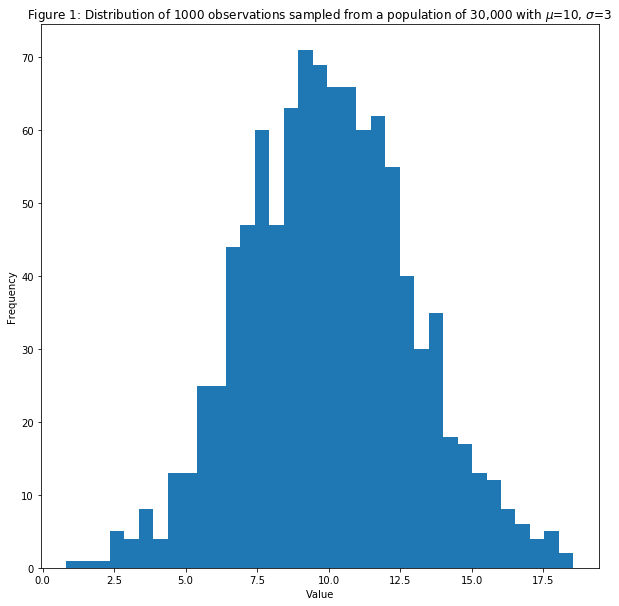

In [90]:
#emprically observed, synthically generated PDF
mod1=lambda t:np.random.normal(10,3,t) #anonymous function

#Form a population of 30,000 individual, with average=10 and scale=3
population = mod1(30000)
#Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with $\mu$=10, $\sigma$=3")
mu_obs=observation.mean()
mu_obs

In [91]:
#Transition model and proposal distribution (normal)
#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))[0]]

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.
def log_lik_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)


In [92]:
accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 50000,observation,acceptance)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


In [93]:
accepted[-10:,1]

array([2.86322771, 3.00432987, 2.9423702 , 2.8743125 , 3.02426533,
       2.89186024, 3.04251013, 2.9388532 , 2.87045758, 2.85205938])

In [94]:
print(accepted.shape)

(8222, 2)


(8222, 2)

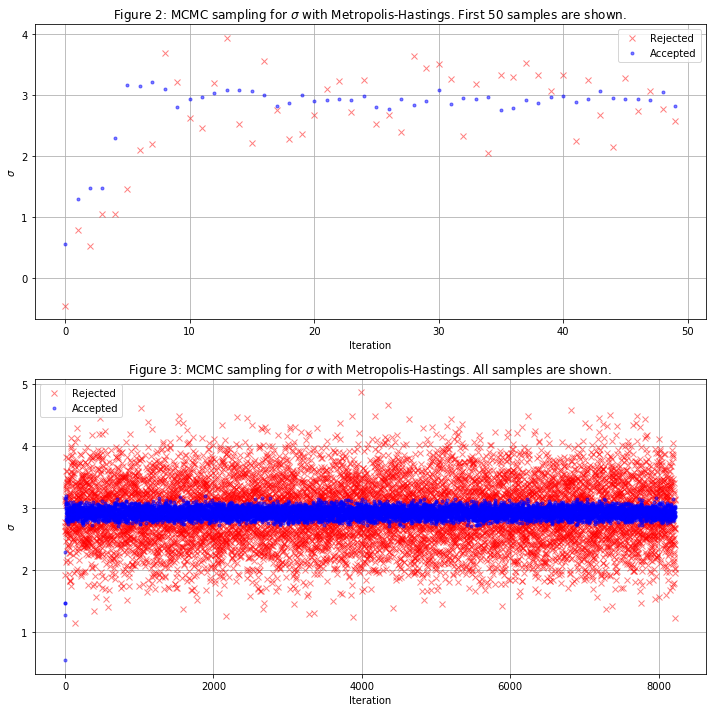

In [95]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()



fig.tight_layout()
accepted.shape

In [102]:
accepted

array([[9.99805073, 0.54580211],
       [9.99805073, 1.28461241],
       [9.99805073, 1.47562819],
       ...,
       [9.99805073, 2.9388532 ],
       [9.99805073, 2.87045758],
       [9.99805073, 2.85205938]])

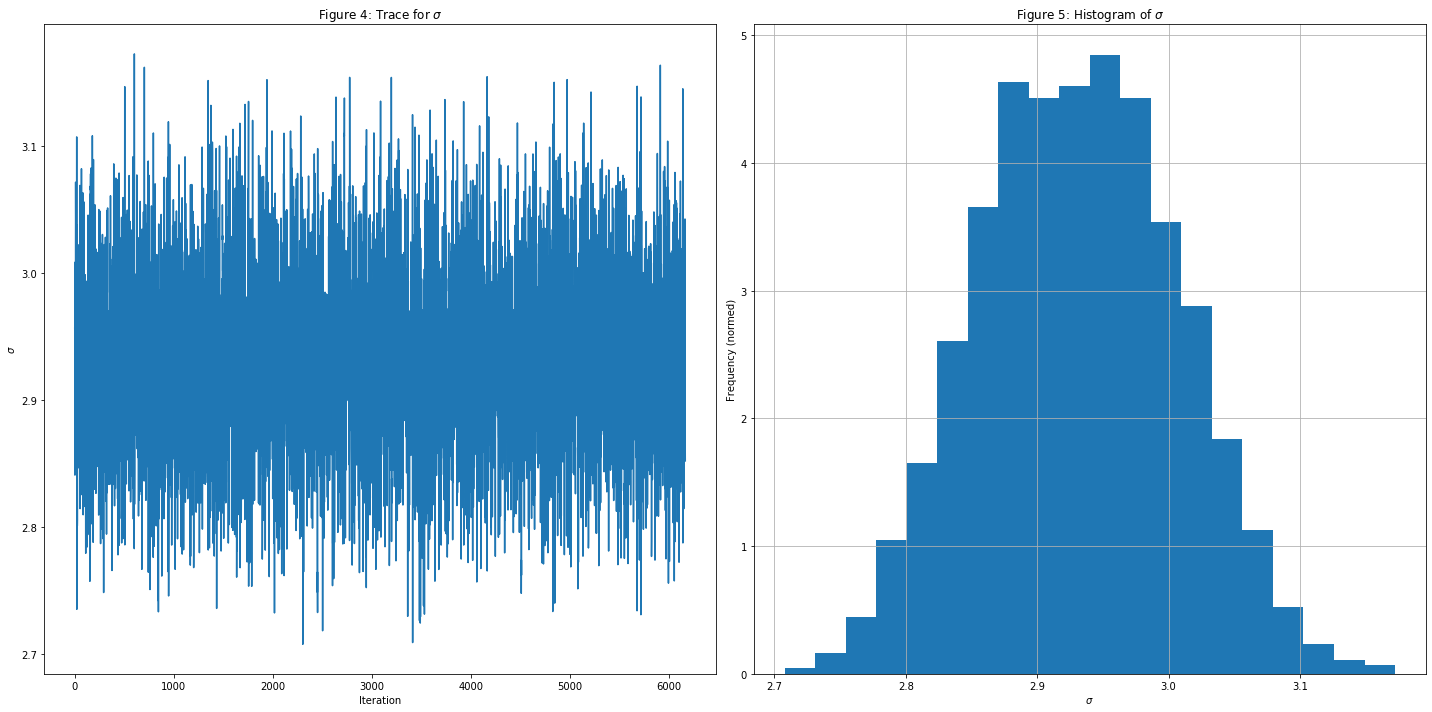

In [98]:
show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Figure 4: Trace for $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)

ax.hist(accepted[hist_show:,1], bins=20,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Figure 5: Histogram of $\sigma$")
fig.tight_layout()


ax.grid("off")

10.074383982547658 2.925749441102521


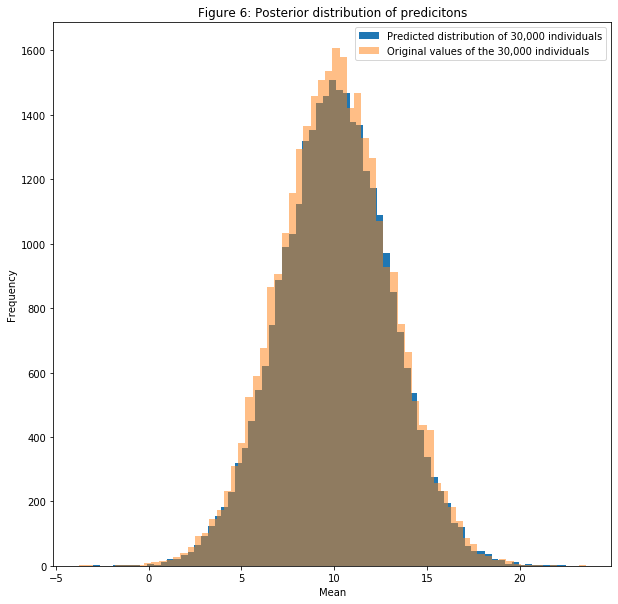

In [18]:
mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.normal(mu,sigma,t)
observation_gen=model(population.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=70 ,label="Predicted distribution of 30,000 individuals")
ax.hist( population,bins=70 ,alpha=0.5, label="Original values of the 30,000 individuals")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Figure 6: Posterior distribution of predicitons")
ax.legend()

(3238,) (3238,)
1785.042


Text(0.5, 1.0, 'Figure 9: Histogram showing the frequency of sunspot counts over 270 years (1749-2018)')

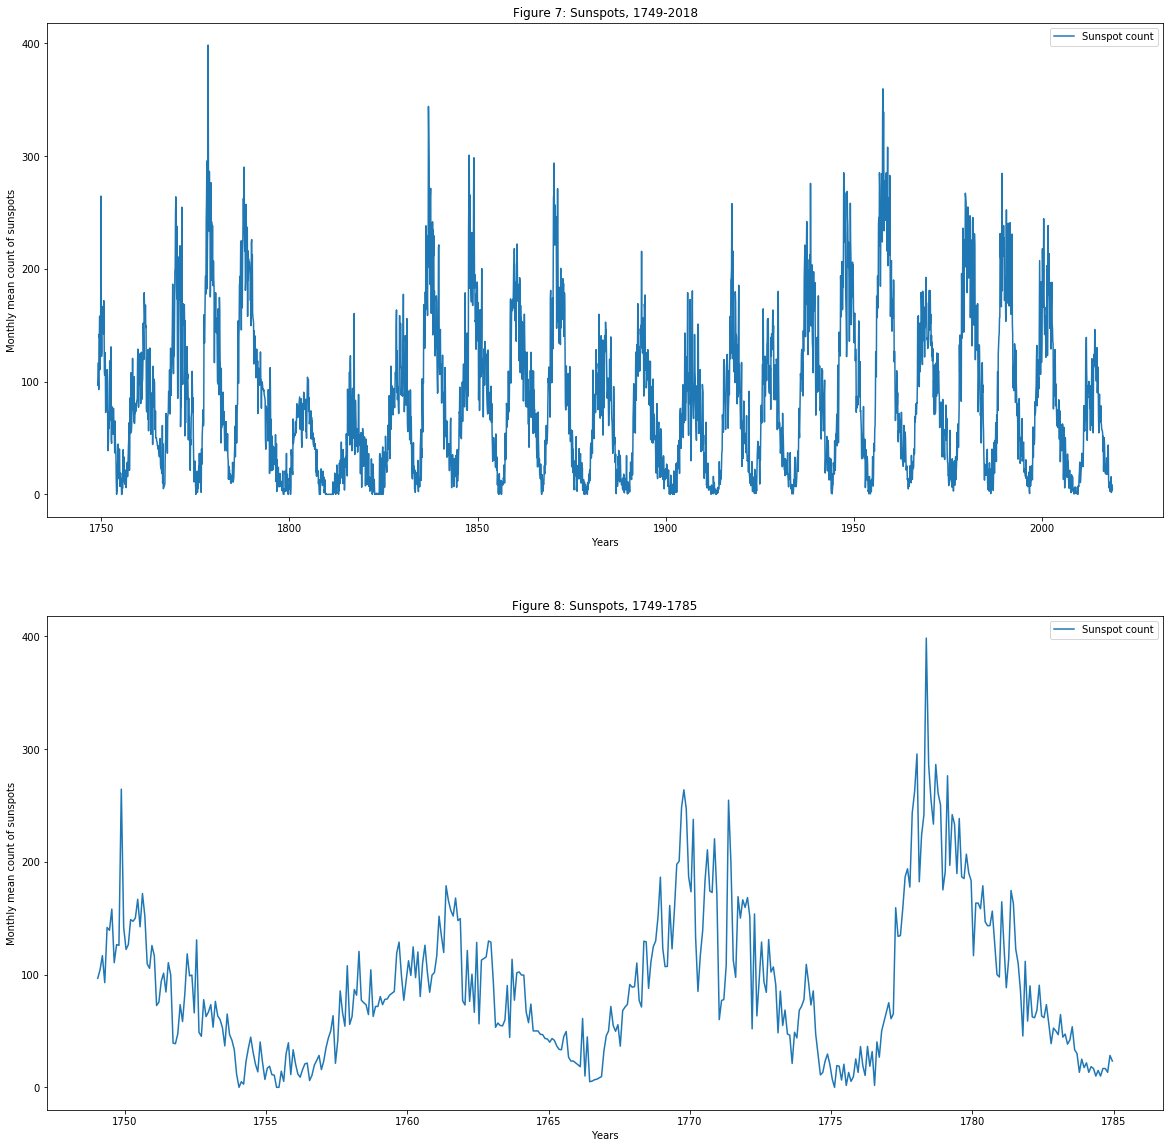

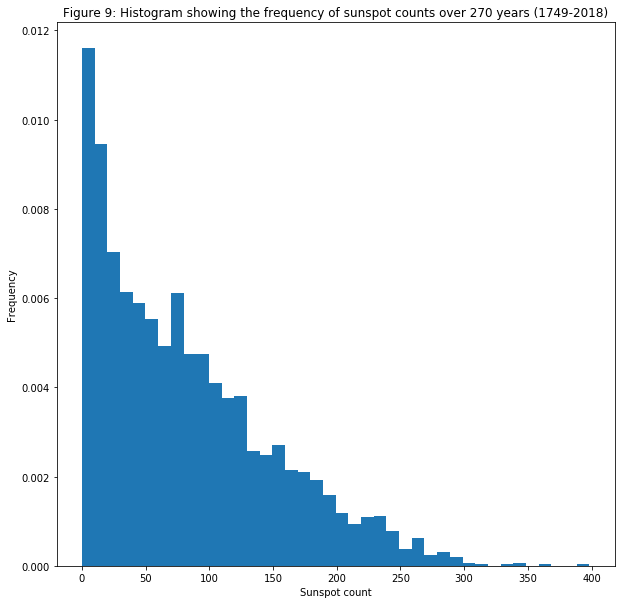

In [5]:
sunspots = np.loadtxt("data/SN_m_tot_V2.0.csv", delimiter=';')
#years is the third column
years = sunspots[:,2]
#activity is the 4th column
activity = sunspots[:,3] + 0.1
print(years.shape,activity.shape)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(2,1,1)

ax.plot(years, activity, label="Sunspot count")
ax.set_yticks(np.arange(0,500,100))
ax.set_xlabel("Years")
ax.set_ylabel("Monthly mean count of sunspots")
ax.set_title("Figure 7: Sunspots, 1749-2018")
ax.legend()


ax = fig.add_subplot(2,1,2)
print(years[432])
ax.plot(years[:432], activity[:432], label="Sunspot count")
ax.set_yticks(np.arange(0,500,100))
ax.set_xlabel("Years")
ax.set_ylabel("Monthly mean count of sunspots")
ax.set_title("Figure 8: Sunspots, 1749-1785")
ax.legend()


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist(activity, bins=40, density=True)
ax.set_xlabel("Sunspot count")
ax.set_ylabel("Frequency")
ax.set_title("Figure 9: Histogram showing the frequency of sunspot counts over 270 years (1749-2018)")

In [44]:
transition_model = lambda x: np.random.normal(x,[0.05,5],(2,))
import math
def prior(w):
    if(w[0]<=0 or w[1] <=0):
        return 0
    else:
        return 1
    
def manual_log_lik_gamma(x,data):
    return np.sum((x[0]-1)*np.log(data) - (1/x[1])*data - x[0]*np.log(x[1]) - np.log(math.gamma(x[0])))
    
def log_lik_gamma(x,data):
    return np.sum(np.log(scipy.stats.gamma(a=x[0],scale=x[1],loc=0).pdf(data)))

In [45]:
accepted, rejected = metropolis_hastings(manual_log_lik_gamma,prior,transition_model,[4, 10], 50000,activity,acceptance)

In [103]:
print(accepted.shape)
accepted[-10:]

(8222, 2)


array([[9.99805073, 2.86322771],
       [9.99805073, 3.00432987],
       [9.99805073, 2.9423702 ],
       [9.99805073, 2.8743125 ],
       [9.99805073, 3.02426533],
       [9.99805073, 2.89186024],
       [9.99805073, 3.04251013],
       [9.99805073, 2.9388532 ],
       [9.99805073, 2.87045758],
       [9.99805073, 2.85205938]])

Text(0.5, 1.0, 'Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.')

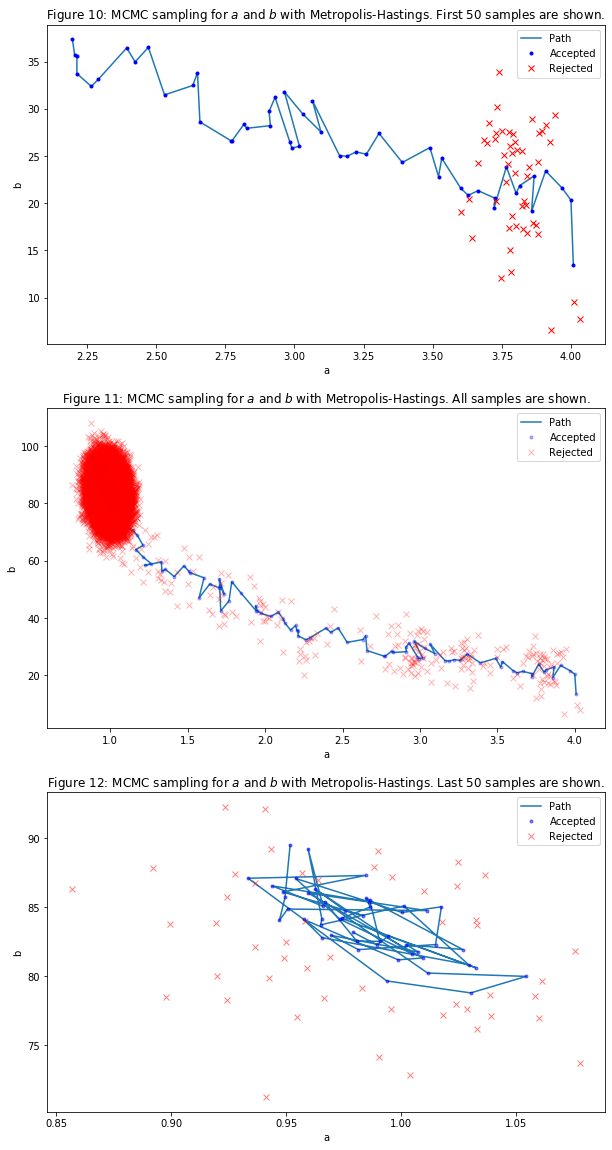

In [47]:
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(3,1,1)
ax.plot(accepted[:50,0], accepted[:50,1], label="Path")
ax.plot(accepted[:50,0], accepted[:50,1], 'b.', label='Accepted')
ax.plot(rejected[:50,0], rejected[:50,1], 'rx', label='Rejected')
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 10: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. First 50 samples are shown.")  


ax = fig.add_subplot(3,1,2)
ax.plot(accepted[:,0], accepted[:,1], label="Path")
ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted',alpha=0.3)
ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected',alpha=0.3)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 11: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. All samples are shown.") 

to_show=50
ax = fig.add_subplot(3,1,3)
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], label="Path")
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax.plot(rejected[-to_show:,0], rejected[-to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.")

Text(0.5, 1.0, '2D histogram showing the joint distribution of $a$ and $b$')

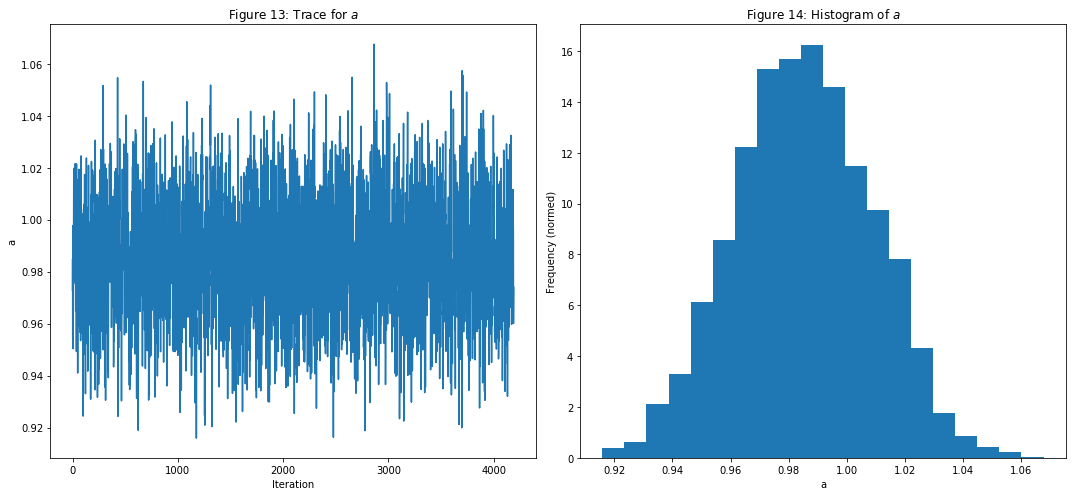

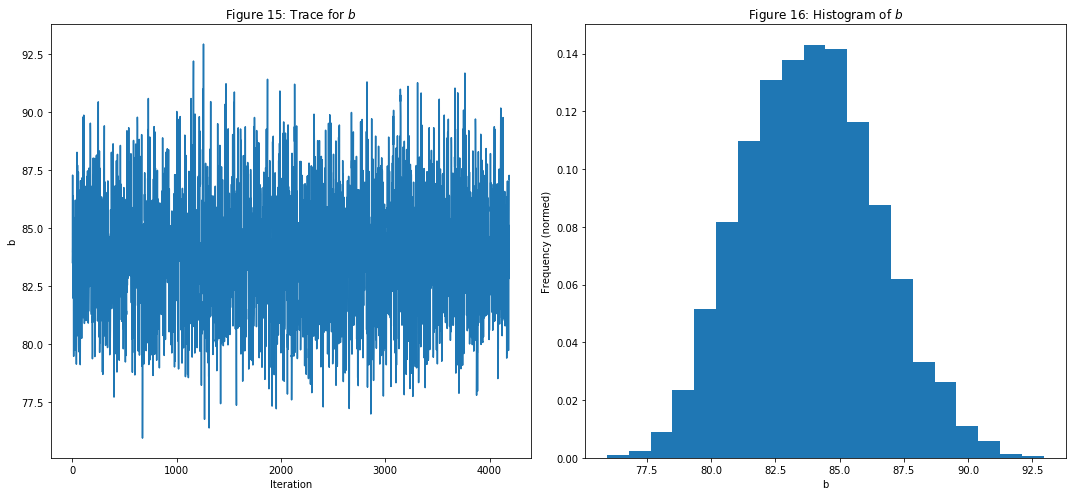

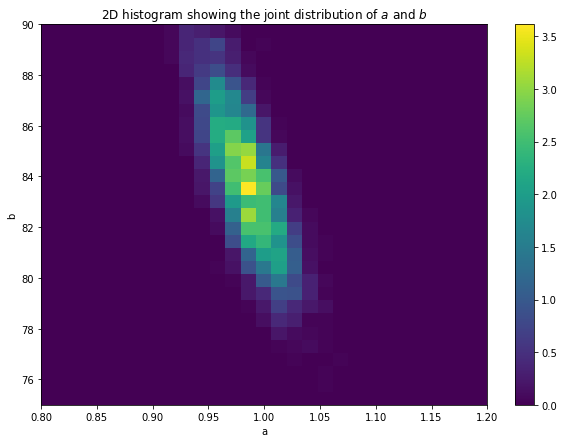

In [27]:
show=int(-0.5*accepted.shape[0])
hist_show=int(-0.50*accepted.shape[0])


fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,0])
ax.set_title("Figure 13: Trace for $a$")
ax.set_xlabel("Iteration")
ax.set_ylabel("a")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,0], bins=20, density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("a")
ax.set_title("Figure 14: Histogram of $a$")
fig.tight_layout()

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Figure 15: Trace for $b$")
ax.set_xlabel("Iteration")
ax.set_ylabel("b")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,1], bins=20, density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("b")
ax.set_title("Figure 16: Histogram of $b$")
fig.tight_layout()

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
xbins, ybins = np.linspace(0.8,1.2,30), np.linspace(75,90,30)
counts, xedges, yedges, im = ax.hist2d(accepted[hist_show:,0], accepted[hist_show:,1], density=True, bins=[xbins, ybins])
ax.set_xlabel("a")
ax.set_ylabel("b")
fig.colorbar(im, ax=ax)
ax.set_title("2D histogram showing the joint distribution of $a$ and $b$")

0.9851081553814054 83.87880708738855


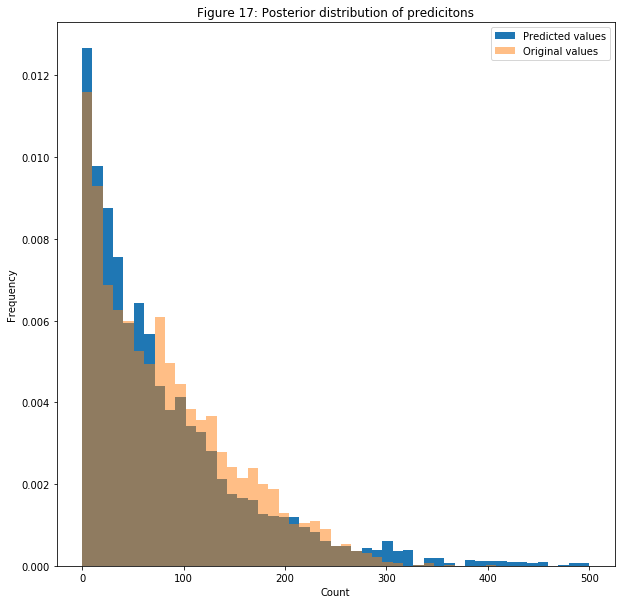

In [28]:
show=-int(0.5*accepted.shape[0])

mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.gamma(mu,sigma,t)
t=np.arange(activity.shape[0])
observation_gen=model(t.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)



ax.hist( observation_gen,bins=np.linspace(0,500,50) ,density=True,label="Predicted values")
ax.hist( activity,bins=np.linspace(0,500,50) ,alpha=0.5,density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Figure 17: Posterior distribution of predicitons")
ax.legend()

0.9851081553814054 83.87880708738855


[(-0.1, 1), Text(0, 0.5, 'autocorrelation'), Text(0.5, 0, 'lag')]

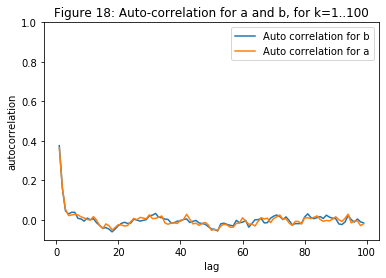

In [29]:

mean_acc_0=accepted[show:,0].mean()
mean_acc_1=accepted[show:,1].mean()
print(mean_acc_0,mean_acc_1)

lag=np.arange(1,100)
def autocorr(accepted,lag):
    num_0=0
    denom_0=0
    num_1=0
    denom_1=0
    for i in range(accepted.shape[0]-lag):
        num_0+=(accepted[i,0]-mean_acc_0)*(accepted[i+lag,0]-mean_acc_0)
        num_1+=(accepted[i,1]-mean_acc_1)*(accepted[i+lag,1]-mean_acc_1)
        denom_0+=(mean_acc_0-accepted[i,0])**2
        denom_1+=(mean_acc_1-accepted[i,1])**2
    rk_0=num_0/denom_0
    rk_1=num_1/denom_1
    return rk_0, rk_1


accepted_reversed=accepted[show:,:]
result=np.zeros((2,lag.shape[0]))
#print(lag)
for l in lag:
    result[:,l-1]=autocorr(accepted_reversed,l)
    
    
###Instead of writing an autocorrelation function, one could simply use thee autocorr function provided in pymc3    
#from pymc3.stats import autocorr

fig, ax = plt.subplots()
#ax.plot(lag, [autocorr(accepted[show:,1], l) for l in lags], label='auto b')
#ax.plot(lag, [autocorr(accepted[show:,0], l) for l in lags], label='auto a')
ax.plot(lag, result[1,:], label='Auto correlation for b')
ax.plot(lag, result[0,:], label='Auto correlation for a')
ax.legend(loc=0)
ax.set_title("Figure 18: Auto-correlation for a and b, for k=1..100")
ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

970.0034838712539

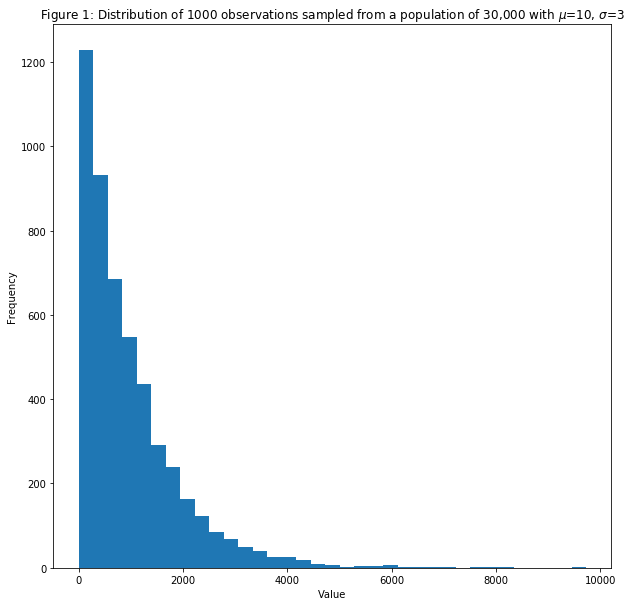

In [63]:
#emprically observed, synthically generated PDF
mod1=lambda t:np.random.exponential(1.0/250) #anonymous function

#Form a population of 30,000 individual, with average=10 and scale=3
population = mod1(5000)
#Assume we are only able to observe 1,000 of these individuals.
#observation = population[np.random.randint(0, 30000, 1000)]
observation = np.random.exponential(1000, size=5000)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with $\mu$=10, $\sigma$=3")
mu_obs=observation.mean()
mu_obs


In [66]:
#Transition model and proposal distribution (normal)
#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))[0]]

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.
def log_lik_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)
accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 50000,observation,acceptance)

array([1440.52654089, 1568.68778666,  560.91061217, ..., 2877.88457342,
         46.98723453, 2429.58584506])

## Metropolis-adjusted Langevin algorithm (MALA)

$$ Y \sim \mathcal{N}(X_n + h \frac{\nabla\pi(X_n)}{\pi(X_n)}, 2hI) $$

$$ \alpha(X_n, Y) = \frac{\pi(Y)}{\pi(X_n)} \exp \Big\{ \frac{1}{4h}\Big( \big|Y - X_n - h \frac{\nabla\pi(X_n)}{\pi(X_n)}\big|^2 - \big|X_n - Y - h \frac{\nabla\pi(Y)}{\pi(Y)}\big|^2 \Big) \Big\}$$

In [132]:
def mala(pi, grad_pi, x_0, h, n_of_steps):
    #x = x_0
    accepted = []
    rejected = []
    
    x = np.zeros((n_of_steps, x_0.size))
    x[0] = x_0
    #sumx = np.zeros(x_0.shape)
    scale = np.sqrt(2*h)
    for i in range(1, n_of_steps):
        y = np.random.normal(x[i-1]+(h/pi(x[i-1]))*grad_pi(x[i-1]), scale)
        sqsum1 = np.sum((y-x[i-1]-(h/pi(x[i-1]))*grad_pi(x[i-1]))**2)
        sqsum2 = np.sum((x[i-1]-y-(h/pi(y))*grad_pi(y))**2)
        alpha_cand = (pi(y)/pi(x[i-1])) * np.exp( (sqsum1 - sqsum2) / (4*h) )
        alpha = min(alpha_cand, 1)
        if np.random.rand() < alpha:
            x[i] = y
            accepted.append(y)
        else:
            x[i] = x[i-1]
            rejected.append(x[i])   
    #return x
    return np.array(accepted), np.array(rejected)

def norm(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-x**2/2)

def grad_norm(x):
    return -(x/np.sqrt(2*np.pi))*np.exp(-x**2/2)

In [139]:
#mala_samples = mala(norm, grad_norm, np.array([0]), 0.01, 10**5)
accepted, rejected = mala(norm, grad_norm, np.array([0]), 0.01, 10**5)

In [144]:
len(accepted)

22

(99977, 1)

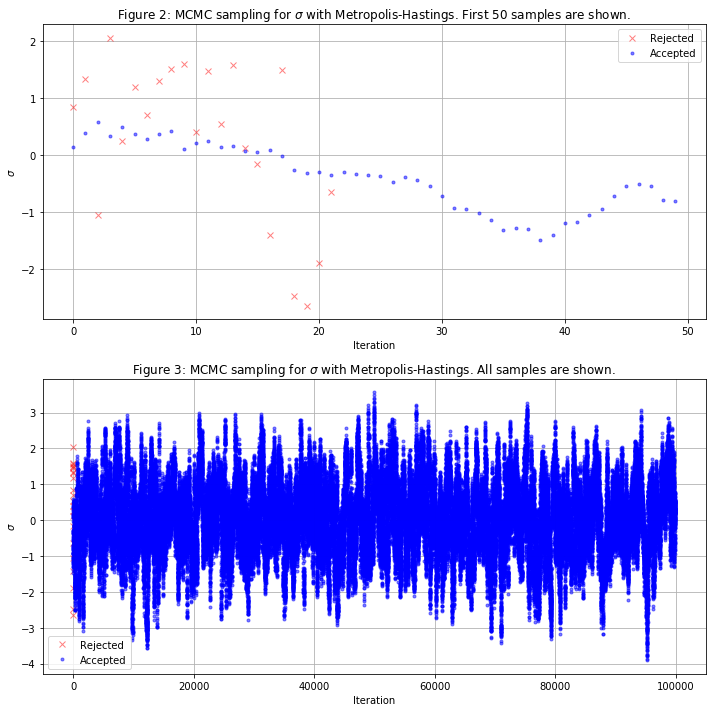

In [141]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()



fig.tight_layout()
accepted.shape

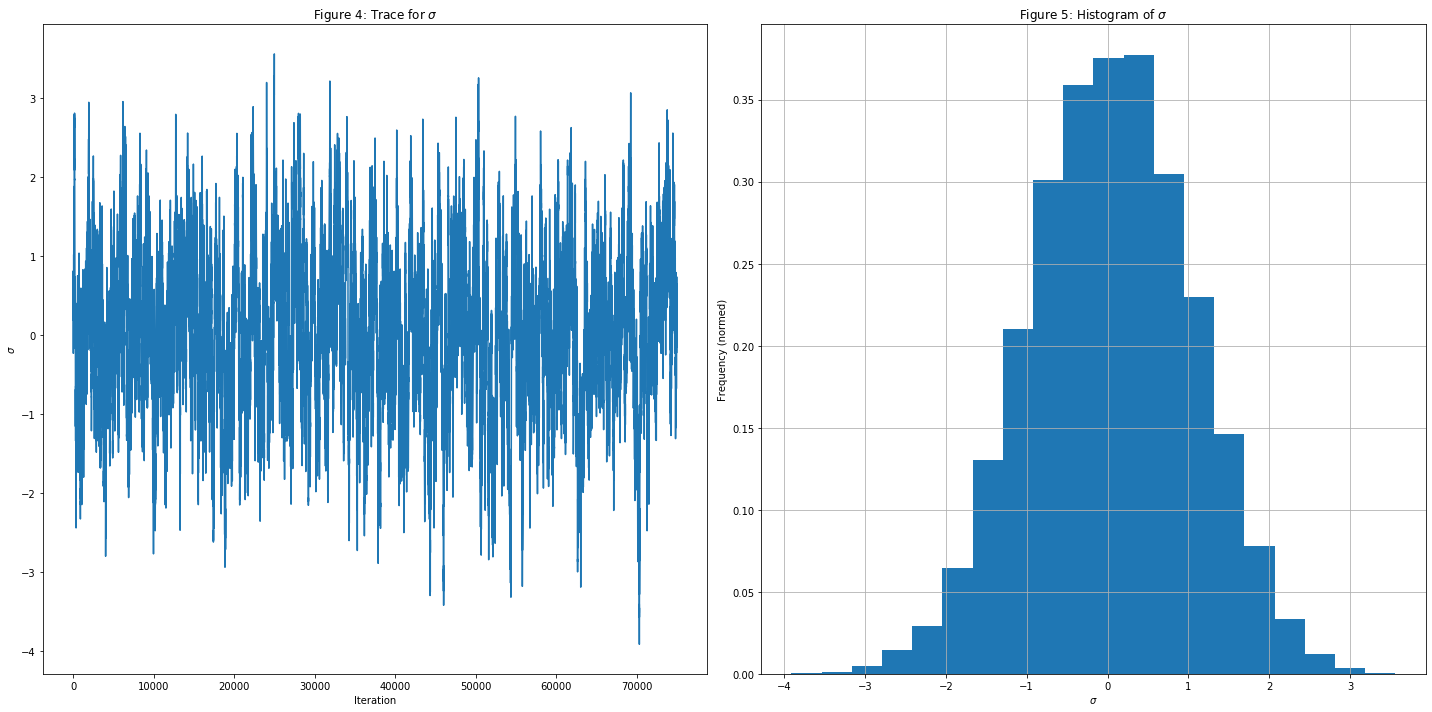

In [143]:
show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:])
ax.set_title("Figure 4: Trace for $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:], bins=20,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Figure 5: Histogram of $\sigma$")
fig.tight_layout()


ax.grid("off")

In [146]:
mu=accepted[show:].mean()
sigma=accepted[show:].mean()
print(mu, sigma)
'''
model = lambda t,mu,sigma:np.random.normal(mu,sigma,t)
observation_gen=model(population.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=70 ,label="Predicted distribution of 30,000 individuals")
ax.hist( population,bins=70 ,alpha=0.5, label="Original values of the 30,000 individuals")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Figure 6: Posterior distribution of predicitons")
ax.legend()'''

0.040760887185101326 0.040760887185101326


'\nmodel = lambda t,mu,sigma:np.random.normal(mu,sigma,t)\nobservation_gen=model(population.shape[0],mu,sigma)\nfig = plt.figure(figsize=(10,10))\nax = fig.add_subplot(1,1,1)\nax.hist( observation_gen,bins=70 ,label="Predicted distribution of 30,000 individuals")\nax.hist( population,bins=70 ,alpha=0.5, label="Original values of the 30,000 individuals")\nax.set_xlabel("Mean")\nax.set_ylabel("Frequency")\nax.set_title("Figure 6: Posterior distribution of predicitons")\nax.legend()'

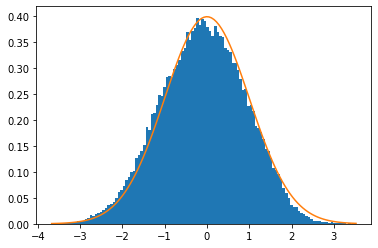

In [136]:
accepted, bins, _ = plt.hist(mala_samples, bins=120, density=True)
dens = np.zeros((bins.size, 1))
for i in range(dens.size):
    dens[i] = norm(bins[i])
plt.plot(bins, dens)

In [20]:
np.plot(activity)

AttributeError: module 'numpy' has no attribute 'plot'

In [10]:
transition_model = lambda x: np.random.normal(x,[0.05,5],(2,)) #gamma distribution

import math
def prior(w):
    if(w[0]<=0 or w[1] <=0):
        return 0
    else:
        return 1
    
def manual_log_lik_gamma(x,data):
    return np.sum((x[0]-1)*np.log(data) - (1/x[1])*data - x[0]*np.log(x[1]) - np.log(math.gamma(x[0])))
    
def log_lik_gamma(x,data):
    return np.sum(np.log(scipy.stats.gamma(a=x[0],scale=x[1],loc=0).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init, iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)


#accepted, rejected = metropolis_hastings(manual_log_lik_gamma,prior,transition_model,[4, 10], 50000,activity,acceptance)
accepted, rejected = metropolis_hastings(manual_log_lik_gamma,prior,transition_model,[5.159, 2.67], 50000 ,activity,acceptance)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


In [16]:
accepted[1] #array([ 5.22098649, 10.36263922]) #first
accepted[len(accepted)-1] #array([ 1.00366699, 83.42165076]) #last

array([ 1.00366699, 83.42165076])

Text(0.5, 1.0, 'Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.')

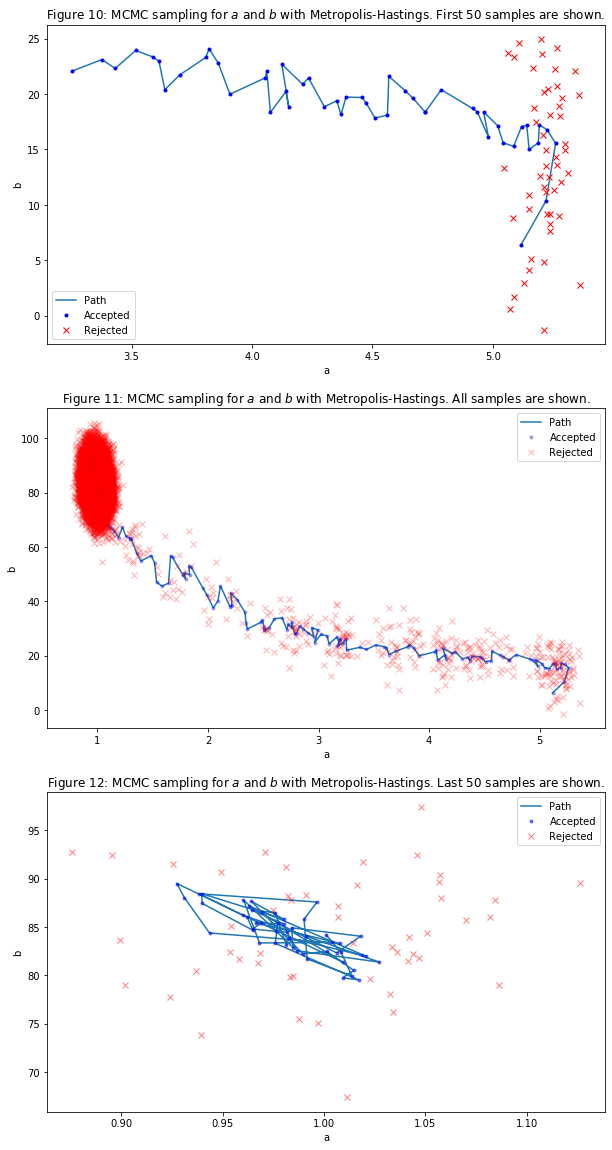

In [11]:
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(3,1,1)
ax.plot(accepted[:50,0], accepted[:50,1], label="Path")
ax.plot(accepted[:50,0], accepted[:50,1], 'b.', label='Accepted')
ax.plot(rejected[:50,0], rejected[:50,1], 'rx', label='Rejected')
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 10: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. First 50 samples are shown.")  


ax = fig.add_subplot(3,1,2)
ax.plot(accepted[:,0], accepted[:,1], label="Path")
ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted',alpha=0.3)
ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected',alpha=0.3)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 11: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. All samples are shown.") 

to_show=50
ax = fig.add_subplot(3,1,3)
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], label="Path")
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax.plot(rejected[-to_show:,0], rejected[-to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.")

In [62]:
#observation_gam.mean()
#observation_gam.std()

3.987265945280923

Text(0.5, 1.0, 'Figure 1: Poisson distribution of 1000 observations sampled from a population of 30,000 with lambda=5')

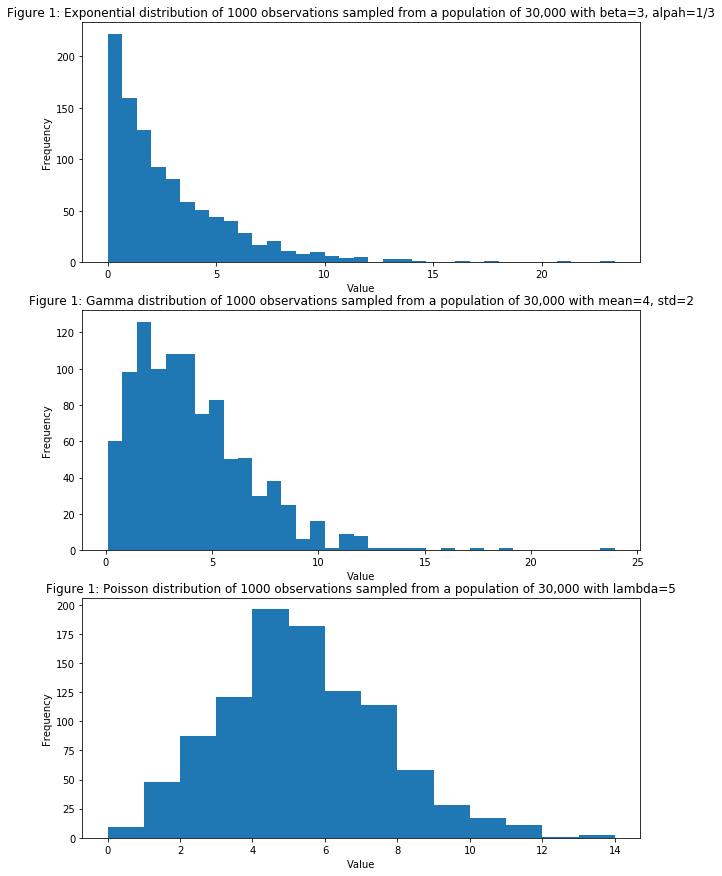

In [86]:
#Synthetically generated - (exponential,gamma and poisson)

#From a population of 30,000 individual, sample 1000 from relevant distributions
population_size = 30000
sample_size = 1000


#exponential distribution
beta = 3  #beta = 1/lambda, must be not be negative
mod_exp=lambda t:np.random.exponential(beta,t) 
population = mod_exp(population_size)
observation_exp = population[np.random.randint(0, population_size, sample_size)]

#gamma distribution
shape, scale = 2., 2.  # mean=4, std=2*sqrt(2)
mod_gamma=lambda t:np.random.gamma(shape, scale,t) 
population = mod_gamma(population_size)
observation_gam = population[np.random.randint(0, population_size, sample_size)]

#poisson distributioni
lam = 5 #expectation interval lambda, must no be negative
mod_poisson=lambda t:np.random.poisson(lam, t) 
population = mod_poisson(population_size)
observation_poi = population[np.random.randint(0, population_size, sample_size)]


#ploting 
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(3,1,1)

ax.hist( observation_exp,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Exponential distribution of 1000 observations sampled from a population of 30,000 with beta=3, alpah=1/3")

ax2 = fig.add_subplot(3,1,2)
ax2.hist( observation_gam,bins=35 ,)
ax2.set_xlabel("Value")
ax2.set_ylabel("Frequency")
ax2.set_title("Figure 1: Gamma distribution of 1000 observations sampled from a population of 30,000 with mean=4, std=2")

ax3 = fig.add_subplot(3,1,3)
ax3.hist(observation_poi,bins=14)
ax3.set_xlabel("Value")
ax3.set_ylabel("Frequency")
ax3.set_title("Figure 1: Poisson distribution of 1000 observations sampled from a population of 30,000 with lambda=5")


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


Text(0.5, 1.0, 'Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.')

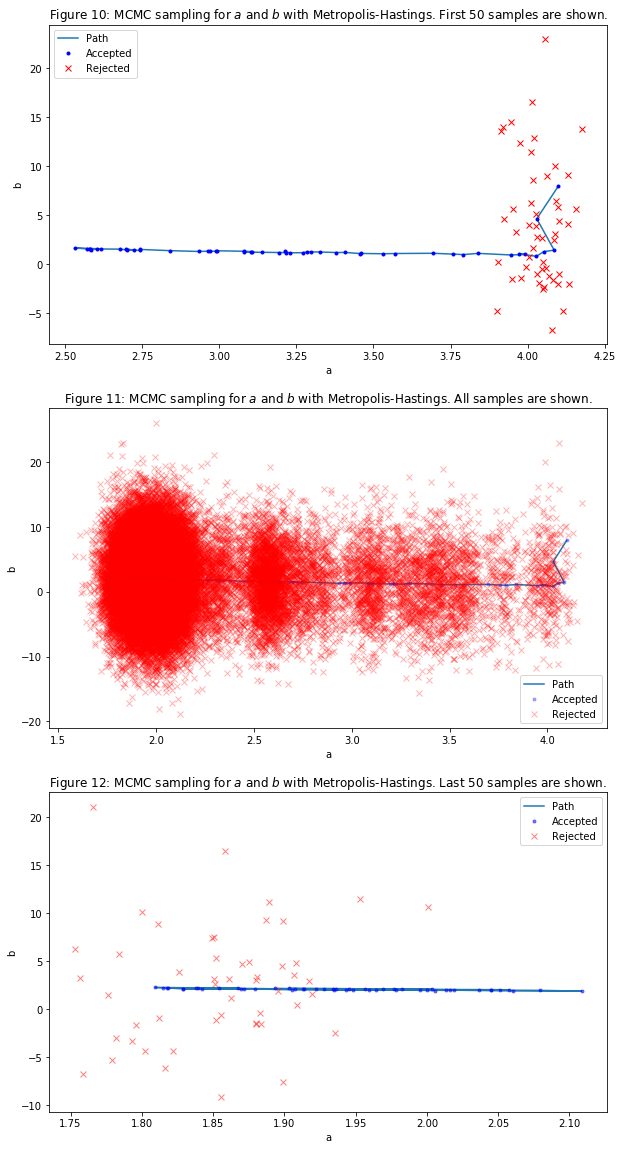

In [79]:
import math

#transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))] #gamma distribution
transition_model = lambda x: np.random.normal(x,[0.05,5],(2,))

def prior(w):
    if(w[0]<=0 or w[1] <=0):
        return 0
    else:
        return 1
    
def manual_log_lik_gamma(x,data):
    return np.sum((x[0]-1)*np.log(data) - (1/x[1])*data - x[0]*np.log(x[1]) - np.log(math.gamma(x[0])))
    
def log_lik_gamma(x,data):
    return np.sum(np.log(scipy.stats.gamma(a=x[0],scale=x[1],loc=0).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init, iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)


#accepted, rejected = metropolis_hastings(manual_log_lik_gamma,prior,transition_model,[4, 10], 50000,activity,acceptance)
accepted, rejected = metropolis_hastings(manual_log_lik_gamma,prior,transition_model,[4, 10], 50000 ,observation_gam,acceptance)

fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(3,1,1)
ax.plot(accepted[:50,0], accepted[:50,1], label="Path")
ax.plot(accepted[:50,0], accepted[:50,1], 'b.', label='Accepted')
ax.plot(rejected[:50,0], rejected[:50,1], 'rx', label='Rejected')
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 10: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. First 50 samples are shown.")  


ax = fig.add_subplot(3,1,2)
ax.plot(accepted[:,0], accepted[:,1], label="Path")
ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted',alpha=0.3)
ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected',alpha=0.3)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 11: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. All samples are shown.") 

to_show=50
ax = fig.add_subplot(3,1,3)
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], label="Path")
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax.plot(rejected[-to_show:,0], rejected[-to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.")

In [78]:
print(accepted.shape)
accepted[-10:]

(532, 2)


array([[2.07886014, 1.85352719],
       [2.12597479, 1.91234734],
       [2.14811688, 1.80832819],
       [2.12641098, 1.93886114],
       [2.13029908, 1.84785311],
       [2.1345799 , 1.8799607 ],
       [2.10599638, 1.91027335],
       [2.08238089, 1.89078397],
       [2.04315546, 1.93277235],
       [2.06420179, 1.98421726]])

#### starts a =4 and b=  10. and with 573 pairs of samples, the last value of a is 1.86261 and b = 2.171593. 

<function __main__.<lambda>(x)>